# Assignment 1

# Setting up Notebook

Start by creating a venv using the requirements. Use the following commands

python3 -m venv venv

source venv/bin/activate

pip install -r requirements.txt

In [58]:
# Imports

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt


In [59]:
# Global config / constants

ALPHA = 0.99
WINDOW = 500                 # rolling window size 
LAMBDA_EWMA = 0.94           # EWMA decay
THRESH_POT_Q = 0.95          # POT threshold quantile (top 5% largest losses)
RNG_SEED = 42

DATA_PATH = "DataLab1.xlsx"  

In [60]:
df = pd.read_excel(DATA_PATH)
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)
df["Profit"] = df["PL"].astype(float)
df["Loss"] = -df["PL"].astype(float)  # losses = -PL
del df["PL"]

In [61]:
# Inspecting Data

print(df.head())
print(df.isna().sum())
print(len(df))


        Date  Profit   Loss
0 2005-01-01   190.0 -190.0
1 2005-01-02   190.0 -190.0
2 2005-01-03  -220.0  220.0
3 2005-01-05   120.0 -120.0
4 2005-01-06   450.0 -450.0
Date      0
Profit    0
Loss      0
dtype: int64
1008


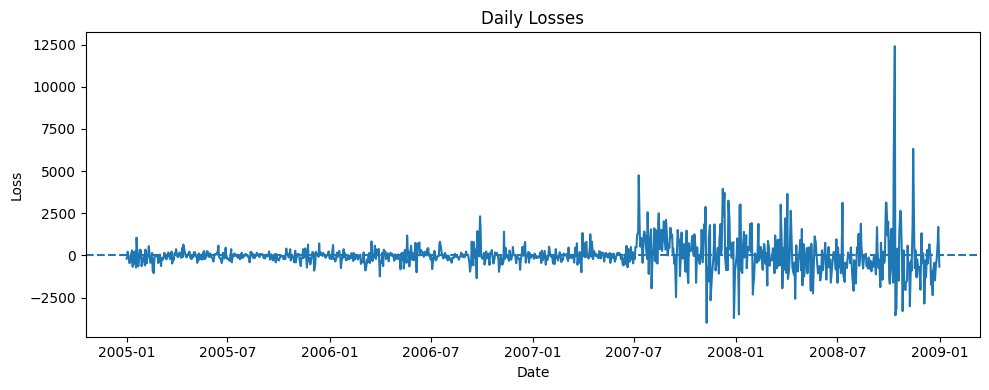

In [62]:
# Plotting Data

plt.figure(figsize=(10, 4))
plt.plot(df["Date"], df["Loss"])
plt.axhline(0, linestyle="--")
plt.title("Daily Losses")
plt.xlabel("Date")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()


## Problem 1

1. Apply basic historical simulation to the losses in order to estimate VaR for each day in the 
test  period.  Use  a  rolling  (moving)  window  of  size  500.  This  means  that  for  the  first  VaR 
estimate  you  use  the  first  500  loss  observations,  for  the  second  VaR  estimate  you drop  the 
very first loss observation but add observation 501 (keeping the window size fixed at 500).

In [63]:
var_hs = []

for t in range(WINDOW, len(df)):
    window = df["Loss"].iloc[t-WINDOW:t]
    var_hs.append(window.quantile(ALPHA))

# Add VaR column (first 500 will be NaN automatically)
df["VaR_HS_Basic"] = [np.nan]*WINDOW + var_hs

df.iloc[WINDOW:WINDOW+5][["Date", "Loss", "VaR_HS_Basic"]]

,Date,Loss,VaR_HS_Basic
500,2006-12-26,150.0,1051.3
501,2006-12-28,-150.0,1051.3
502,2006-12-29,20.0,1051.3
503,2006-12-31,-30.0,1051.3
504,2007-01-01,-30.0,1051.3


## Problem 2

2a.  Construct  unexpected  losses  by  subtracting  the  sample  mean  (mu)  estimated  as  the 
average of the first 500 loss observations (the unexpected losses are et in the EWMA formula.) 
Subtract this mean from all loss observations.  For simplicity, keep the estimate of mu fixed. 
This means no parameter updating of mu. 

b.  Use  the  EWMA  conditional  variance  approximate  GARCH  model  to  calculate  a  variance 
observation corresponding to each loss observation (both in the estimation and test period): 
𝜎𝑡2 =(1−𝜆)𝑒𝑡−12 +𝜆𝜎𝑡−12  for 𝑡=1,2,...,1008 
Use the standard values 𝜆=0.94, 𝑒02 =0 and 𝜎02 = variance of first 500 loss observations.

c.  Calculate  the  EWMA  conditional  standard  deviations  (the  square  root  of  the  EWMA 
conditional variances).

In [64]:
# 2a: fixed mean from first WINDOW losses
mu_fixed = df["Loss"].iloc[:WINDOW].mean()
df["e"] = df["Loss"] - mu_fixed

print(mu_fixed)
df.head()

-44.08


,Date,Profit,Loss,VaR_HS_Basic,e
0,2005-01-01,190.0,-190.0,NaN,-145.92
1,2005-01-02,190.0,-190.0,NaN,-145.92
2,2005-01-03,-220.0,220.0,NaN,264.08
3,2005-01-05,120.0,-120.0,NaN,-75.92
4,2005-01-06,450.0,-450.0,NaN,-405.92


In [65]:

# 2b: EWMA  variance

sigma2 = np.zeros(len(df))

# initial variance
sigma2[0] = df["e"].iloc[:WINDOW].var()

for t in range(1, len(df)):
    sigma2[t] = (
        (1 - LAMBDA_EWMA) * df["e"].iloc[t-1]**2
        + LAMBDA_EWMA * sigma2[t-1]
    )

df["Sigma2_EWMA"] = sigma2

In [66]:
# 2 c

df["Sigma_EWMA"] = np.sqrt(df["Sigma2_EWMA"])

df[["Date", "Loss", "Sigma2_EWMA", "Sigma_EWMA"]].head(10)

,Date,Loss,Sigma2_EWMA,Sigma_EWMA
0,2005-01-01,-190.0,124734.823246,353.178175
1,2005-01-02,-190.0,118528.292636,344.279382
2,2005-01-03,220.0,112694.153862,335.699499
3,2005-01-05,-120.0,110116.799414,331.838514
4,2005-01-06,-450.0,103855.622233,322.266384
5,2005-01-08,-410.0,107510.547683,327.888011
6,2005-01-09,40.0,109093.761606,330.293448
7,2005-01-11,300.0,102972.302694,320.892977
8,2005-01-12,-670.0,103897.427316,322.331239
9,2005-01-14,180.0,121170.132461,348.095005


## Problem 3

3.  Construct  volatility  scaled  losses  by using the standard deviations  calculated  in  2c.  Recall 
that we need an estimate of 𝜎𝑇+1 to construct the scaled losses, i.e. an estimate of volatility 
for ‘’the next day’’. This means that we have to reconstruct the whole series of scaled losses for each new 𝜎𝑇+1, so we have to create as many new rescaled loss series as we have days in 
the test period.  That is your matrix of scaled losses should by 500x508. 
Hint: The code will be something like 

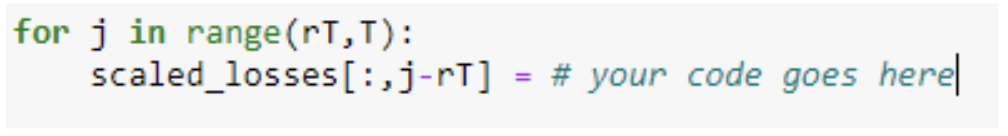
 
rt is the size of the rolling sample and T the total sample size.

In [67]:
T = len(df)
n_test = T - WINDOW

scaled_losses = np.zeros((WINDOW, n_test))

for j in range(WINDOW, T):
    window_loss = df["Loss"].iloc[j-WINDOW:j].values
    window_sig  = df["Sigma_EWMA"].iloc[j-WINDOW:j].values
    sig_next    = df["Sigma_EWMA"].iloc[j]

    scaled_losses[:, j-WINDOW] = window_loss * (sig_next / window_sig)

scaled_losses.shape

(500, 508)

In [68]:
scaled_losses[:5, 0]

array([-217.59703515, -223.22139471,  265.07283192, -146.26744888,
       -564.79486349])

## Problem 4

Apply the basic historical simulation to the volatility scaled losses to estimate VaR  and ES 
for each day in the test period.  
Plot the Losses (negative PL), the basic historical simulation and the volatility weighted VaR 
estimate for each day in the test period. 

In [69]:
# VaR and ES from volatility-scaled losses (each column is one test day)
var_scaled = np.quantile(scaled_losses, ALPHA, axis=0)

es_scaled = []
for k in range(scaled_losses.shape[1]):
    col = scaled_losses[:, k]
    v = var_scaled[k]
    es_scaled.append(col[col >= v].mean())

# Put into df (align with test period rows)
df["VaR_HS_Scaled"] = [np.nan] * WINDOW + list(var_scaled)
df["ES_HS_Scaled"] = [np.nan] * WINDOW + list(es_scaled)


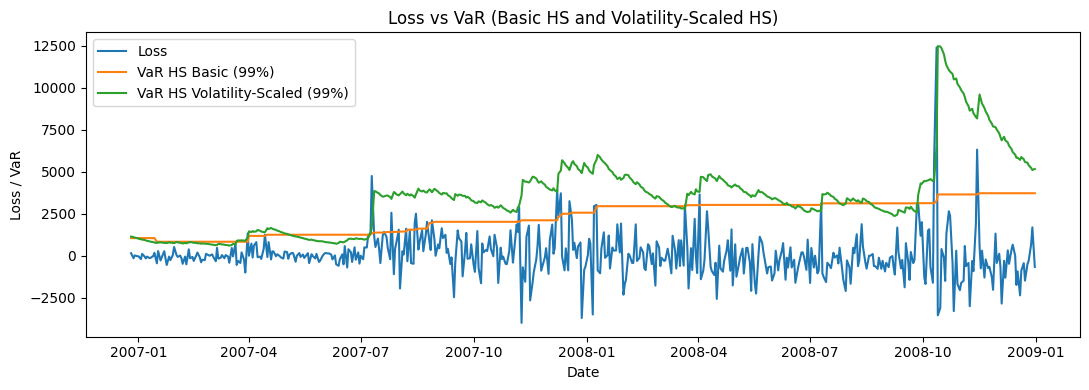

,Date,Loss,VaR_HS_Basic,VaR_HS_Scaled,ES_HS_Scaled
500,2006-12-26,150.0,1051.3,1138.047133,1319.840061
501,2006-12-28,-150.0,1051.3,1111.455669,1289.000847
502,2006-12-29,20.0,1051.3,1080.066029,1252.596991
503,2006-12-31,-30.0,1051.3,1048.093745,1215.517419
504,2007-01-01,-30.0,1051.3,1016.210920,1178.541595


In [70]:
# Plot over test period
test_df = df.iloc[WINDOW:].copy()

plt.figure(figsize=(11, 4))
plt.plot(test_df["Date"], test_df["Loss"], label="Loss")
plt.plot(test_df["Date"], test_df["VaR_HS_Basic"], label="VaR HS Basic (99%)")
plt.plot(test_df["Date"], test_df["VaR_HS_Scaled"], label="VaR HS Volatility-Scaled (99%)")
plt.title("Loss vs VaR (Basic HS and Volatility-Scaled HS)")
plt.xlabel("Date")
plt.ylabel("Loss / VaR")
plt.legend()
plt.tight_layout()
plt.show()

# Quick check
test_df[["Date", "Loss", "VaR_HS_Basic", "VaR_HS_Scaled", "ES_HS_Scaled"]].head()

## Problem 5

5a. We now move on to parametric approaches. Test if the Loss data is normally distributed. 
Also compute the first four moments. How do they look compared the SP500 returns? Hint: 
SP500 (daily) returns are typically, leptokurtic and left skewed with a mean very close to zero. 

5 b. Estimate 𝜇,𝜎 and 𝜈 (degrees of freedom) for each day in the test period by using a rolling 
window of the 500 previous observations assuming a student t-distribution. Also estimate 𝜇,𝜎 
for each day in the test period by using a rolling window of the 500 previous observations and 
assume a normal distribution.  

5c. Estimate VaR and ES under the normal distribution and under the  t-distribution for each 
day in the test period using the estimates of 𝜇,𝜎 and 𝜈. For those days (if any) you get a value 
of 𝜈<2, set 𝜈 =2.1.

Moments (Loss):
Mean:      1.2054
Std dev:   960.4231
Skewness:  2.875
Excess kurtosis: 32.8755

Jarque-Bera test for normality:
JB stat: 46312.9782
p-value: 0.0


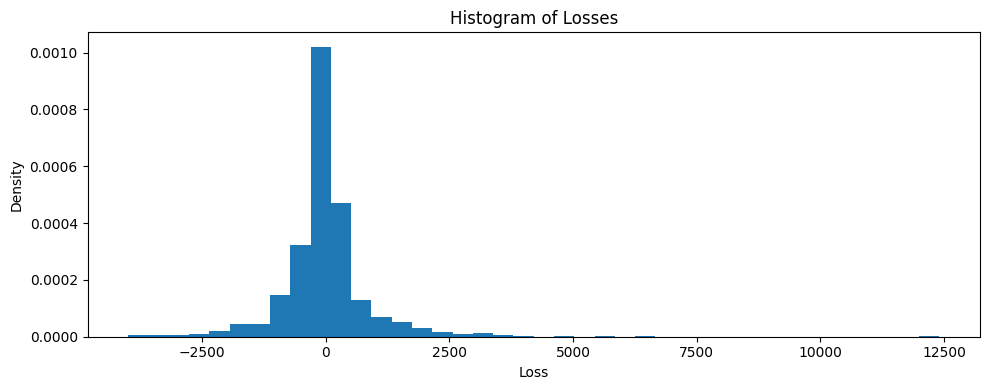

In [71]:
# 5a

x = df["Loss"].values

# moments
mean_ = np.mean(x)
std_ = np.std(x, ddof=1)
skew_ = stats.skew(x, bias=False)
kurt_ = stats.kurtosis(x, fisher=True, bias=False)  # excess kurtosis (0 for normal)

print("Moments (Loss):")
print("Mean:     ", round(mean_, 4))
print("Std dev:  ", round(std_, 4))
print("Skewness: ", round(skew_, 4))
print("Excess kurtosis:", round(kurt_, 4))

# normality test: Jarque-Bera
jb_stat, jb_p = stats.jarque_bera(x)
print("\nJarque-Bera test for normality:")
print("JB stat:", round(jb_stat, 4))
print("p-value:", jb_p)

# quick visual check
plt.figure(figsize=(10, 4))
plt.hist(x, bins=40, density=True)
plt.title("Histogram of Losses")
plt.xlabel("Loss")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

The loss data does not visually look normally distributed. The Jarque-Bera test also rejects it at any relevant significance level.

Skew is significantly positive. This indicates a long right tail of losses, but a clustering of smaller negative losses (profits)

Kurtosis is very high at around 33. This shows that extreme values are much more common than in a normal distribution.

As for similarity to S&P500 returns they look somewhat similar. The mean for losses for this data is positive, while for the S&P500 it has historically been close to zero or slightly negative (profit). The values for skewness and excess kurtosis are significantly larger in magnitude than what we saw in class for S&P500 returns where skewness was below 1 and daily returns showed excess kurtosis of 16.

In [72]:
# 5b

T = len(df)
n_test = T - WINDOW

# Containers
mu_norm = []
sigma_norm = []

mu_t = []
sigma_t = []
nu_t = []

for t in range(WINDOW, T):
    window = df["Loss"].iloc[t-WINDOW:t].values
    
    # Normal estimates
    mu_norm.append(window.mean())
    sigma_norm.append(window.std(ddof=1))
    
    # Student-t MLE estimates
    df_est, loc_est, scale_est = stats.t.fit(window)
    
    mu_t.append(loc_est)
    sigma_t.append(scale_est)
    nu_t.append(df_est)

# Store in dataframe
df["mu_norm"] = [np.nan]*WINDOW + mu_norm
df["sigma_norm"] = [np.nan]*WINDOW + sigma_norm

df["mu_t"] = [np.nan]*WINDOW + mu_t
df["sigma_t"] = [np.nan]*WINDOW + sigma_t
df["nu_t"] = [np.nan]*WINDOW + nu_t

df.iloc[WINDOW:WINDOW+5][
    ["Date", "mu_norm", "sigma_norm", "mu_t", "sigma_t", "nu_t"]
]



,Date,mu_norm,sigma_norm,mu_t,sigma_t,nu_t
500,2006-12-26,-44.08,353.178175,-52.574265,210.779605,2.723047
501,2006-12-28,-43.40,353.223972,-51.447907,211.135462,2.730718
502,2006-12-29,-43.32,353.195231,-51.327656,210.924927,2.725794
503,2006-12-31,-43.72,353.009622,-51.734838,209.889135,2.703965
504,2007-01-01,-43.54,352.993594,-0.535727,217.297974,2.811527


In [73]:
# 5c

z_alpha = stats.norm.ppf(ALPHA)

var_norm = []
es_norm = []

var_t = []
es_t = []

for t in range(WINDOW, len(df)):
    
    # --- Normal ---
    mu_n = df["mu_norm"].iloc[t]
    sigma_n = df["sigma_norm"].iloc[t]
    
    var_n = mu_n + sigma_n * z_alpha
    es_n = mu_n + sigma_n * stats.norm.pdf(z_alpha) / (1 - ALPHA)
    
    var_norm.append(var_n)
    es_norm.append(es_n)
    
    
    # --- Student-t ---
    mu_tt = df["mu_t"].iloc[t]
    sigma_tt = df["sigma_t"].iloc[t]
    nu_tt = df["nu_t"].iloc[t]
    
    if nu_tt < 2:
        nu_tt = 2.1
    
    q = stats.t.ppf(ALPHA, df=nu_tt)
    
    var_student = mu_tt + sigma_tt * q
    
    pdf_q = stats.t.pdf(q, df=nu_tt)
    
    es_student = mu_tt + sigma_tt * (
        (nu_tt + q**2) / (nu_tt - 1)
    ) * pdf_q / (1 - ALPHA)
    
    var_t.append(var_student)
    es_t.append(es_student)


df["VaR_Normal"] = [np.nan]*WINDOW + var_norm
df["ES_Normal"]  = [np.nan]*WINDOW + es_norm

df["VaR_t"] = [np.nan]*WINDOW + var_t
df["ES_t"]  = [np.nan]*WINDOW + es_t

df.iloc[WINDOW:WINDOW+5][
    ["VaR_Normal", "ES_Normal", "VaR_t", "ES_t"]
]

,VaR_Normal,ES_Normal,VaR_t,ES_t
500,777.535296,897.215494,986.872988,1628.107209
501,778.321836,898.017553,987.104981,1625.286334
502,778.334975,898.020953,987.885556,1628.076297
503,777.503184,897.126264,989.976733,1638.951742
504,777.645897,897.263546,1041.036735,1656.011939


## Problem 6

Estimate VaR and ES using the POT method on a rolling sample of 500 observations, use the 
5% largest values as the threshold. Plot your VaR estimate over time.  

In [75]:
var_pot = []
es_pot = []

for t in range(WINDOW, len(df)):
    
    window = df["Loss"].iloc[t-WINDOW:t].values
    
    # threshold = 95% quantile
    u = np.quantile(window, THRESH_POT_Q)
    
    exceedances = window[window > u] - u
    Nu = len(exceedances)
    N = len(window)
    
    # Fit GPD to exceedances
    xi, loc, beta = stats.genpareto.fit(exceedances, floc=0)
    
    # VaR formula
    var_alpha = u + (beta/xi) * (
        ((N/Nu)*(1-ALPHA))**(-xi) - 1
    )
    
    # ES formula
    if xi != 1:
        es_alpha = (var_alpha + beta - xi*u) / (1 - xi)
    else:
        es_alpha = np.nan
    
    var_pot.append(var_alpha)
    es_pot.append(es_alpha)

df["VaR_POT"] = [np.nan]*WINDOW + var_pot
df["ES_POT"]  = [np.nan]*WINDOW + es_pot

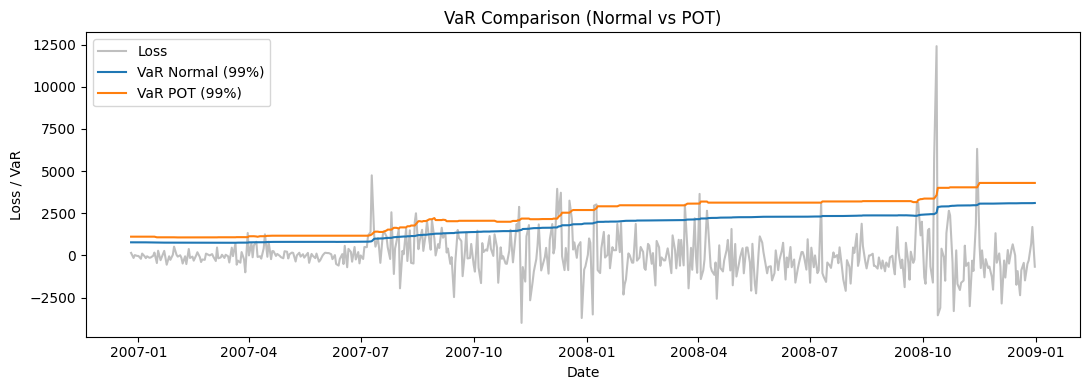

In [77]:
test_df = df.iloc[WINDOW:]

plt.figure(figsize=(11,4))

# Loss in light gray
plt.plot(
    test_df["Date"],
    test_df["Loss"],
    color="gray",
    alpha=0.5,
    label="Loss"
)

# Normal VaR
plt.plot(
    test_df["Date"],
    test_df["VaR_Normal"],
    label="VaR Normal (99%)"
)

# POT VaR
plt.plot(
    test_df["Date"],
    test_df["VaR_POT"],
    label="VaR POT (99%)"
)

plt.title("VaR Comparison (Normal vs POT)")
plt.xlabel("Date")
plt.ylabel("Loss / VaR")
plt.legend()
plt.tight_layout()
plt.show()

# Takeaways

This section is just for our sake

In this section, we briefly compare the different Value-at-Risk (VaR) and Expected Shortfall (ES) estimates obtained throughout the exercise. The purpose is not to introduce new methods, but rather to reflect on how the different modelling approaches behave in practice.

The comparison will mainly be visual, focusing on how the various VaR and ES series evolve over time and how they react to periods of high and low volatility. In particular, I will compare:
	•	Basic Historical Simulation
	•	Volatility-Scaled Historical Simulation
	•	Parametric Normal
	•	Parametric Student-t
	•	POT (Extreme Value Theory)

The goal is to understand how modelling assumptions — such as normality, fat tails, or time-varying volatility — influence the estimated level of risk and the responsiveness of the measures during turbulent periods.

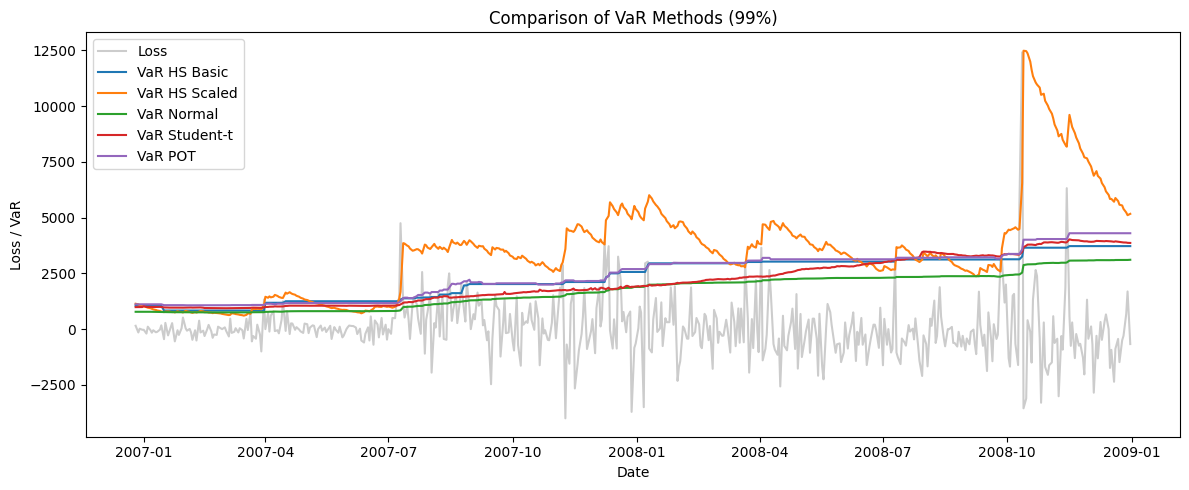

In [78]:
# Plotting VaR

test_df = df.iloc[WINDOW:]

plt.figure(figsize=(12,5))

plt.plot(test_df["Date"], test_df["Loss"],
         color="gray", alpha=0.4, label="Loss")

plt.plot(test_df["Date"], test_df["VaR_HS_Basic"],
         label="VaR HS Basic")

plt.plot(test_df["Date"], test_df["VaR_HS_Scaled"],
         label="VaR HS Scaled")

plt.plot(test_df["Date"], test_df["VaR_Normal"],
         label="VaR Normal")

plt.plot(test_df["Date"], test_df["VaR_t"],
         label="VaR Student-t")

plt.plot(test_df["Date"], test_df["VaR_POT"],
         label="VaR POT")

plt.title("Comparison of VaR Methods (99%)")
plt.xlabel("Date")
plt.ylabel("Loss / VaR")
plt.legend()
plt.tight_layout()
plt.show()

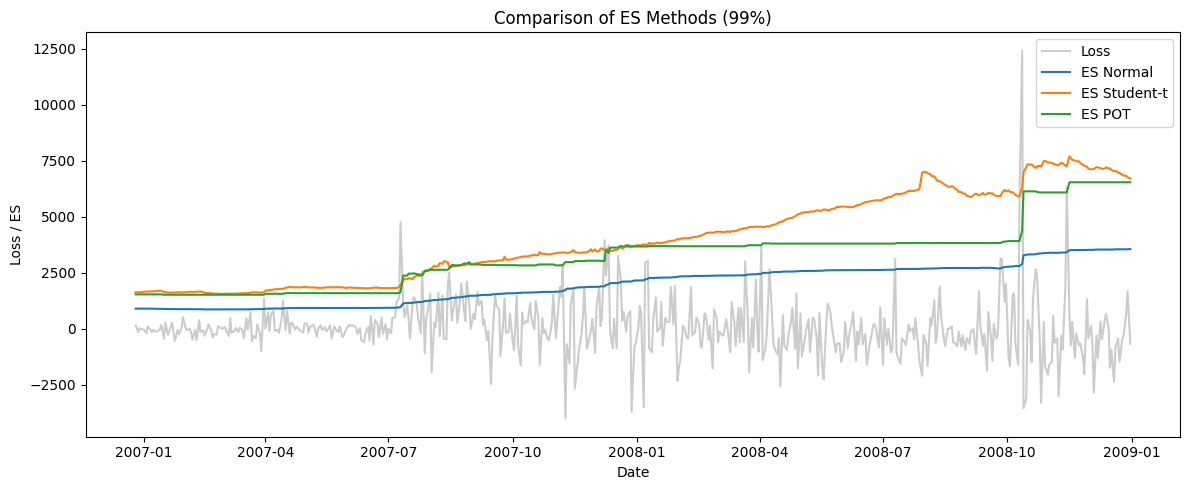

In [79]:
# Plotting ES

plt.figure(figsize=(12,5))

plt.plot(test_df["Date"], test_df["Loss"],
         color="gray", alpha=0.4, label="Loss")

plt.plot(test_df["Date"], test_df["ES_Normal"],
         label="ES Normal")

plt.plot(test_df["Date"], test_df["ES_t"],
         label="ES Student-t")

plt.plot(test_df["Date"], test_df["ES_POT"],
         label="ES POT")

plt.title("Comparison of ES Methods (99%)")
plt.xlabel("Date")
plt.ylabel("Loss / ES")
plt.legend()
plt.tight_layout()
plt.show()

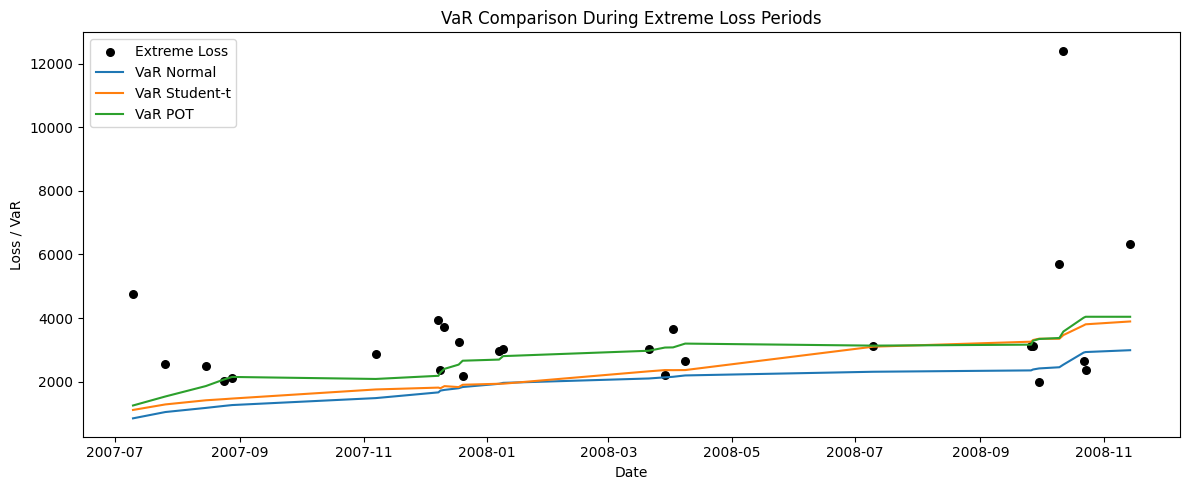

In [81]:
# Zooming in on extreme losses

threshold = test_df["Loss"].quantile(0.95)
extreme_df = test_df[test_df["Loss"] > threshold]

plt.figure(figsize=(12,5))

# Extreme losses as dots
plt.scatter(
    extreme_df["Date"],
    extreme_df["Loss"],
    color="black",
    s=30,
    label="Extreme Loss"
)

plt.plot(extreme_df["Date"], extreme_df["VaR_Normal"],
         label="VaR Normal")

plt.plot(extreme_df["Date"], extreme_df["VaR_t"],
         label="VaR Student-t")

plt.plot(extreme_df["Date"], extreme_df["VaR_POT"],
         label="VaR POT")

plt.title("VaR Comparison During Extreme Loss Periods")
plt.xlabel("Date")
plt.ylabel("Loss / VaR")
plt.legend()
plt.tight_layout()
plt.show()